# 深度学习3.2：线性回归的代码实现

**我们要实现什么？**
1. 数据集的生成（不是重点）
2. 随机梯度下降（SGD）的实现
   
   2.1. 重抽样

   2.2. 定义损失函数
   
   2.3. 梯度下降优化的实现
3. 使用我们的模型

In [143]:
%matplotlib inline
import random
import torch as t
import matplotlib.pyplot as plt

### 生成数据集

In [144]:
def synthetic_data(w, b, num_examples):
    X = t.normal(0, 1, (num_examples, len(w)))
    y = t.matmul(X, w) + b # matmul是矩阵乘法，返回矩阵乘积
    y += t.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = t.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.type

<function Tensor.type>

In [145]:
nozoi = [features[0],labels[0]]
print('第一组数据的残差为',features[0] @ true_w.reshape((-1,1)) + true_b - labels[0])
nozoi # 侦察一下

第一组数据的残差为 tensor([-0.0079])


[tensor([-0.4702, -0.8209]), tensor([6.0585])]

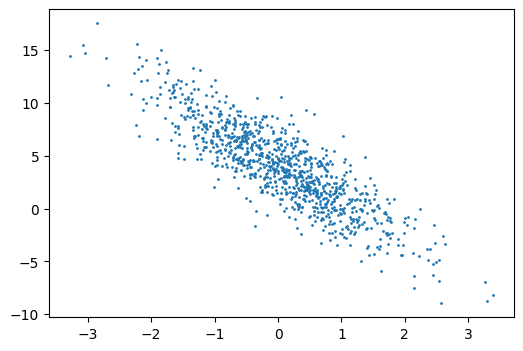

In [146]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s=1) # plt.scatter(横坐标数据[列表],纵坐标数据[列表],s=点的大小)

### 重新取样
随机地从样本中抽取容量为 $b$ 的小样本。

*我们首先讲解一下 `yield` 的用法：*

In [147]:
# 首先解释一下什么是 yield 关键词
def yield_teach(teach_num):
    for i in range(teach_num):
        print('第{}次'.format(i))
        yield i # 如果这里换成 return i，就无法一直输出了
        
yield_result = yield_teach(3)
# 访问生成器的结果，需要使用 next 函数
print(next(yield_result))
print(next(yield_result))
print(next(yield_result))
print('我是分割线')
# 也可以使用 for 循环
yield_result2 = yield_teach(4)
for i in yield_result2:
    print(i)

第0次
0
第1次
1
第2次
2
我是分割线
第0次
0
第1次
1
第2次
2
第3次
3


In [148]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 生成从 0 到 num_examples - 1 的索引列表
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    # 根据打乱的索引列表，抽取前 batch_size 个样本
    for i in range(0, num_examples, batch_size):
        batch_indices = t.tensor(
            indices[i: min(i + batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

*演示一下迭代：*

In [149]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5054, -1.8532],
        [ 0.8411,  1.0256],
        [ 1.5719,  1.5153],
        [-0.4951,  0.4392],
        [ 1.3654,  1.2095],
        [-1.1673,  0.2202],
        [-0.3031,  1.1615],
        [ 0.6677, -1.0678],
        [ 0.0622, -0.7946],
        [-0.8875, -0.7155]]) 
 tensor([[11.5135],
        [ 2.3866],
        [ 2.1885],
        [ 1.7145],
        [ 2.8285],
        [ 1.1154],
        [-0.3676],
        [ 9.1687],
        [ 7.0153],
        [ 4.8579]])


### 定义模型
这里我们实现的是线性模型

In [150]:
def linereg(X, w, b):
    return t.matmul(X, w) + b

接下来，我们的任务就变为了如何找到合适的 $w$ 和 $b$。也就是“求参”，换言之“训练”。

### 损失函数
下面的代码返回以下矩阵函数：
$$
\begin{pmatrix}
\frac{(\hat{y_1} - y_1)^2}{2} \\
\vdots \\
\frac{(\hat{y_m} - y_m)^2}{2} \\
\end{pmatrix}
$$
该函数记录了每个样本的损失值。在后面的代码中我们会使用 `loss.sum()` 来计算所有样本的损失值之和，求它的梯度。

In [151]:
def loss(y_hat, y):
    return ((y_hat - y.reshape(y_hat.shape)) ** 2) / 2

### 优化算法
#### 实现 SGD 算法：
- `params`：待更新的参数，我们把它打包在一起，形如 `params = [w, b]`
- `lr`：学习率，即 $\eta$
- `batch_size`：小批量样本的大小
#### 逻辑：
- 往负梯度方向更新
#### 注意：
- 要考虑到 `batch_size` 的影响，因此我们需要规范化步长
- 注意每次计算完成后都要清理内存： `params.grad.zero_()`

In [152]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with t.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练
现在把所有的东西整合到一起：
```
初始化参数-->抽取样本-->求损失函数-->求梯度-->更新参数--> (if t == T) 输出
    ↑                                         ↓
    |-----------------------------------------| (else)

其中：
    求损失函数:
        1. 调用 linereg 计算当前参数下的预测值
        2. 调用 loss 计算损失值
```

In [153]:
# 初始化
w = t.normal(0, 0.01, size=(2,1), requires_grad=True)
b = t.zeros(1, requires_grad=True)

In [154]:
lr = 0.03
num_epochs = 3
net = linereg

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with t.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046946
epoch 2, loss 0.000180
epoch 3, loss 0.000048


In [155]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')
print(w,b)

w的估计误差: tensor([-0.0003, -0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)
tensor([[ 2.0003],
        [-3.3992]], requires_grad=True) tensor([4.1991], requires_grad=True)
